# Import Data

In [1]:
import pandas as pd
import numpy as np
import os

from dlmslib.torch_models import trees, nlp_models

import gc

In [2]:
DATA_ROOT = '../input/'
ORIGINAL_DATA_FOLDER = os.path.join(DATA_ROOT, 'movie-review-sentiment-analysis-kernels-only')
TMP_DATA_FOLDER = os.path.join(DATA_ROOT, 'kaggle_review_sentiment_tmp_data')
TREEBANK_DATA_FOLDER = os.path.join(DATA_ROOT, 'stanford-sentiment-treebank')

In [3]:
train_data_path = os.path.join(ORIGINAL_DATA_FOLDER, 'train.tsv')
test_data_path = os.path.join(ORIGINAL_DATA_FOLDER, 'test.tsv')
sub_data_path = os.path.join(ORIGINAL_DATA_FOLDER, 'sampleSubmission.csv')

train_df = pd.read_csv(train_data_path, sep="\t")
test_df = pd.read_csv(test_data_path, sep="\t")
sub_df = pd.read_csv(sub_data_path, sep=",")

### Define a Tree Node Class

In [44]:
class LabeledTextBinaryTreeNode(object):  # a node in the tree
    def __init__(self, label, text=None):
        self.label = label
        self.text = text
        self.left = None  # reference to left child
        self.right = None  # reference to right child

    def __str__(self):
        if self.is_leaf():
            return '[{0}:{1}]'.format(self.text, self.label)
        return '({0} <- [{1}:{2}] -> {3})'.format(self.left, self.text, self.label, self.right)

    def is_leaf(self):
        # true if we have finished performing fowardprop on this node (note,
        # there are many ways to implement the recursion.. some might not
        # require this flag)
        return self.left is None and self.right is None

    def get_leaf_texts(self):
        # from left to right
        if self.is_leaf():
            return [self.text]
        else:
            return self.left.get_leaf_texts() + self.right.get_leaf_texts()

    def get_transitions(self, shift_symbol='SHIFT', reduce_symbol='REDUCE'):
        # from left to right
        if self.is_leaf():
            return [shift_symbol, ]
        else:
            return self.left.get_transitions(shift_symbol=shift_symbol, reduce_symbol=reduce_symbol) + \
                   self.right.get_transitions(shift_symbol=shift_symbol, reduce_symbol=reduce_symbol) + [reduce_symbol, ]

    def get_non_leaf_labels_post_order(self):
        if self.is_leaf():
            return list()
        else:
            return self.left.get_non_leaf_labels_post_order() + \
                   self.right.get_non_leaf_labels_post_order() + [self.label]

    def get_labels_in_transition_order(self):
        if self.is_leaf():
            return [None]
        else:
            return self.left.get_labels_in_transition_order() + \
                   self.right.get_labels_in_transition_order() + [self.label]

    def get_nodes_in_transition_order(self):
        if self.is_leaf():
            return [None]
        else:
            return self.left.get_nodes_in_transition_order() + \
                   self.right.get_nodes_in_transition_order() + [self]

    def get_leaf_labels(self):
        # from left to right
        if self.is_leaf():
            return [self.label]
        else:
            return self.left.get_leaf_labels() + \
                   self.right.get_leaf_labels()

    def get_leaf_nodes(self):
        # from left to right
        if self.is_leaf():
            return [self]
        else:
            return self.left.get_leaf_nodes() + \
                   self.right.get_leaf_nodes()

    @classmethod
    def parse_ptb_string(cls, ptb_string, open_char='(', close_char=')'):
        tokens = []
        for toks in ptb_string.strip().split():
            tokens += list(toks)
        return LabeledTextBinaryTreeNode.__parse_ptb_tokens(tokens, open_char=open_char, close_char=close_char)

    @classmethod
    def __parse_ptb_tokens(cls, tokens, open_char='(', close_char=')'):
        assert tokens[0] == open_char, "Malformed tree"
        assert tokens[-1] == close_char, "Malformed tree"

        split = 2  # position after open and label
        count_open = count_close = 0

        if tokens[split] == open_char:
            count_open += 1
            split += 1
        # Find where left child and right child split
        while count_open != count_close:
            if tokens[split] == open_char:
                count_open += 1
            if tokens[split] == close_char:
                count_close += 1
            split += 1

        # New node
        node = LabeledTextBinaryTreeNode(int(tokens[1]))  # zero index labels

        # leaf Node
        if count_open == 0:
            node.text = ''.join(tokens[2: -1]).lower()  # lower case?
            node.isLeaf = True
            return node

        node.left = LabeledTextBinaryTreeNode.__parse_ptb_tokens(tokens[2: split], open_char=open_char, close_char=close_char)
        node.right = LabeledTextBinaryTreeNode.__parse_ptb_tokens(tokens[split: -1], open_char=open_char, close_char=close_char)

        return node


def read_parse_ptb_tree_bank_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as fid:
        tree_list = [LabeledTextBinaryTreeNode.parse_ptb_string(l) for l in fid.readlines()]
    return tree_list


### Load TreeBank Data

In [45]:
def read_tree_bank_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as fid:
        tree_list = [LabeledTextBinaryTreeNode.parse_ptb_string(l) for l in fid.readlines()]
    return tree_list

train_data_path = os.path.join(TREEBANK_DATA_FOLDER, 'train.txt')
test_data_path = os.path.join(TREEBANK_DATA_FOLDER, 'test.txt')
dev_data_path = os.path.join(TREEBANK_DATA_FOLDER, 'dev.txt')

train_trees = read_tree_bank_file(train_data_path)
test_trees = read_tree_bank_file(test_data_path)
dev_trees = read_tree_bank_file(dev_data_path)

# EDA

In [5]:
import seaborn as sns
from sklearn.feature_extraction import text as sktext

In [6]:
train_df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [7]:
test_df.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [8]:
sub_df.head()

,PhraseId,Sentiment
0,156061,2
1,156062,2
2,156063,2
3,156064,2
4,156065,2


## Find Overlapped Phrases Between Train and Test Data

In [9]:
overlapped = pd.merge(train_df[["Phrase", "Sentiment"]], test_df, on="Phrase", how="inner")
overlap_boolean_mask_test = test_df['Phrase'].isin(overlapped['Phrase'])

## Explore Sentence Id

training and testing data sentences hist:


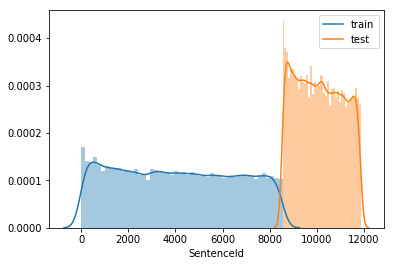

In [10]:
print("training and testing data sentences hist:")
sns.distplot(train_df['SentenceId'], kde_kws={"label": "train"})
sns.distplot(test_df['SentenceId'], kde_kws={"label": "test"})

In [11]:
print("The number of overlapped SentenceId between training and testing data:")
train_overlapped_sentence_id_df = train_df[train_df['SentenceId'].isin(test_df['SentenceId'])]
print(train_overlapped_sentence_id_df.shape[0])

del train_overlapped_sentence_id_df
gc.collect()

The number of overlapped SentenceId between training and testing data:
0


135

In [12]:
pd.options.display.max_colwidth = 250
print("Example of sentence and phrases: ")

sample_sentence_id = train_df.sample(1)['SentenceId'].values[0]
sample_sentence_group_df = train_df[train_df['SentenceId'] == sample_sentence_id]
sample_sentence_group_df

Example of sentence and phrases: 


,PhraseId,SentenceId,Phrase,Sentiment
26489,26490,1215,"Oh , look at that clever angle !",3
26490,26491,1215,Oh,2
26491,26492,1215,", look at that clever angle !",2
26492,26493,1215,look at that clever angle !,4
26493,26494,1215,look at that clever angle,3
26494,26495,1215,at that clever angle,2
26495,26496,1215,that clever angle,3
26496,26497,1215,clever angle,3
26497,26498,1215,angle,2


There is no overlapped sentence between training and testing data. Within each sentence group, the phraseId order is the in-order tanversal over the parsing tree of the sentence text. (This might be a very important information as we can utilized the composition as powerful predictive information).

# Data Preprocessing

In [13]:
from keras.preprocessing import sequence
import gensim
from sklearn import preprocessing as skp

Using TensorFlow backend.


In [14]:
max_len = 50
embed_size = 300
max_features = 30000

## Find Text in the Tree Bank

If we group the data by sentence id, the first phrase in the group is the original sentence text. We can use it to find the parsing tree in the sentiment tree bank.

In [15]:
tree_bank_texts = list(map(
    lambda tree: " ".join(tree.get_leaf_texts()).strip().lower(),
    train_trees + dev_trees + test_trees
))

treebank_text_to_tree = dict(
    list(zip(tree_bank_texts, train_trees + dev_trees + test_trees))
)

Example:

In [16]:
text = test_df[test_df['SentenceId'] == test_df.sample(1)['SentenceId'].values[0]].iloc[0]['Phrase'].strip().lower()
print(treebank_text_to_tree[text])

(((((([this:2] <- [None:2] -> [idea:2]) <- [None:1] -> ([has:2] <- [None:1] -> ([lost:2] <- [None:1] -> ([its:2] <- [None:3] -> [originality:3])))) <- [None:2] -> [...:2]) <- [None:1] -> [and:2]) <- [None:1] -> (([neither:2] <- [None:2] -> [star:2]) <- [None:1] -> ([appears:2] <- [None:0] -> ([very:2] <- [None:1] -> ([excited:3] <- [None:1] -> ([at:2] <- [None:1] -> ([rehashing:2] <- [None:1] -> ([what:2] <- [None:2] -> (([was:2] <- [None:2] -> [basically:2]) <- [None:2] -> ([a:2] <- [None:2] -> ([one-joke:1] <- [None:2] -> [picture:2]))))))))))) <- [None:0] -> [.:2])


## Find Parsing Trees for the Training Data and Test Data

In [17]:
train_sents = train_df.groupby('SentenceId').apply(lambda chunk: chunk.iloc[0]['Phrase'].strip().lower())
train_data_trees = list(map(
    lambda sent: treebank_text_to_tree[sent] if sent in treebank_text_to_tree else None,
    train_sents
))

print(len(train_data_trees))
train_data_trees = list(filter(
    lambda tree: tree is not None,
    train_data_trees
))
print(len(train_data_trees))

8529
8442


Anomaly

In [18]:
train_df[train_df['SentenceId'] == 76]

,PhraseId,SentenceId,Phrase,Sentiment
2005,2006,76,,1
2006,2007,76,Contrived pastiche of caper,2
2007,2008,76,Contrived pastiche,2
2008,2009,76,Contrived,1
2009,2010,76,pastiche,2
2010,2011,76,of caper,2
2011,2012,76,caper,2


In [19]:
test_sents = test_df.groupby('SentenceId').apply(lambda chunk: chunk.iloc[0]['Phrase'].strip().lower())
test_sent_ids = test_df.groupby('SentenceId').apply(lambda chunk: chunk.iloc[0]['SentenceId'])

test_sent_ids = list(map(
    lambda idx: test_sent_ids.iloc[idx] if test_sents.iloc[idx] in treebank_text_to_tree else None,
    range(len(test_sent_ids))
))
test_data_trees = list(map(
    lambda sent: treebank_text_to_tree[sent] if sent in treebank_text_to_tree else None,
    test_sents
))


print(len(test_data_trees))
test_data_trees = list(filter(
    lambda tree: tree is not None,
    test_data_trees
))
print(len(test_data_trees))

3310
3293


# Train Model

## Load Embeddings

In [20]:
def load_embed(file):
    def get_coefs(word,*arr): 
        return word, np.asarray(arr[:len(arr)-1], dtype='float32')
    
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file) if len(o)>15)
        
    return embeddings_index

In [21]:
pretrained_w2v_path = os.path.join(DATA_ROOT, "fasttext-crawl-300d-2m/crawl-300d-2M.vec")
w2v_fasttext = load_embed(pretrained_w2v_path)

## Build Vocab

In [22]:
UNKNOWN_TOKEN = '<UNK>'
EMB_DIM = 300

def map_unknown_token(tree, embeddings_index):
    if tree is None:
        return
    
    word = tree.text
    if word not in embeddings_index:
            tree.text = UNKNOWN_TOKEN
    
    map_unknown_token(tree.left, embeddings_index)
    map_unknown_token(tree.right, embeddings_index)

In [23]:
for tree in train_trees:
    map_unknown_token(tree, w2v_fasttext)
for tree in test_trees:
    map_unknown_token(tree, w2v_fasttext)
for tree in dev_trees:
    map_unknown_token(tree, w2v_fasttext)


flatten = lambda l: [item for sublist in l for item in sublist]
vocab = list(set(flatten([t.get_leaf_texts() for t in (train_trees + test_trees + dev_trees)])))

word2index = {'<UNK>': 0}
wv = np.zeros(shape= (len(vocab), EMB_DIM))
for vo in vocab:
    if word2index.get(vo) is None:
        word2index[vo] = len(word2index)
        
        wv[word2index[vo]] = w2v_fasttext[vo]

## Define Seq-Tree LSTM Model With Thin Stack Implementation

In [46]:
import collections
import itertools

import numpy as np
import sklearn.metrics as sm
import torch
import torch.nn.functional as tfunc
from torch import autograd
from torch import cuda as tcuda
from torch import nn
from torch import optim

In [47]:

class ThinStackHybridLSTM(nn.Module):
    SHIFT_SYMBOL = 1
    REDUCE_SYMBOL = 2

    def __init__(self, embed_matrix, hidden_size, tracker_size, output_size, pad_token_index, alph_droput=0.5,
                 trainable_embed=True,
                 use_gpu=False, train_phase=True):
        super(ThinStackHybridLSTM, self).__init__()

        self.trainable_embed = trainable_embed
        self.use_gpu = use_gpu
        self.train_phase = train_phase
        self.alph_dropout = alph_droput
        self.pad_index = pad_token_index

        if isinstance(embed_matrix, np.ndarray):
            voc_size, embed_size = embed_matrix.shape
            self.embed = nn.Embedding(voc_size, embed_size)
            self.embed.weight = nn.Parameter(torch.from_numpy(embed_matrix).float())
            self.embed.weight.requires_grad = trainable_embed
        elif isinstance(embed_matrix, (int, np.int8, np.int16, np.int32, np.int64, np.int128)):
            embed_size = embed_matrix
            voc_size = hidden_size
            self.embed = nn.Embedding(voc_size, embed_size)
            self.embed.weight.requires_grad = trainable_embed
        else:
            raise ValueError("embed matrix must be either 2d numpy array or integer")

        self.W_in = nn.Linear(embed_size, hidden_size)
        self.reduce = Reduce(hidden_size, tracker_size)
        self.tracker = Tracker(hidden_size, tracker_size)
        self.W_out = nn.Linear(hidden_size, output_size)

    def forward(self, token_index_sequences, transitions):

        buffers = self.embed(token_index_sequences)
        buffers = tfunc.alpha_dropout(tfunc.selu(self.W_in(buffers)), self.alph_dropout, training=self.train_phase)

        outputs0 = tfunc.log_softmax(self.W_out(buffers), 2).transpose(1, 0)

        buffers = [
            list(torch.split(b.squeeze(0), 1, 0))[::-1]
            for b in torch.split(buffers, 1, 0)
        ]

        transitions.transpose_(1, 0)

        # The input comes in as a single tensor of word embeddings;
        # I need it to be a list of stacks, one for each example in
        # the batch, that we can pop from independently. The words in
        # each example have already been reversed, so that they can
        # be read from left to right by popping from the end of each
        # list; they have also been prefixed with a null value.

        # shape = (max_len, batch, embed_dims)
        buffers = [list(map(lambda vec_: torch.cat([vec_, vec_], 1), buf)) for buf in buffers]

        pad_embed = buffers[0][0]
        stacks = [[pad_embed, pad_embed] for _ in buffers]

        self.tracker.reset_state()

        # TODO
        # shape = (max_len, batch)
        num_transitions = transitions.size(0)

        outputs1 = list()
        for i in range(num_transitions):
            trans = transitions[i]
            tracker_states = self.tracker(buffers, stacks)

            lefts, rights, trackings = [], [], []
            batch = list(zip(trans.data, buffers, stacks, tracker_states))

            for bi in range(len(batch)):
                transition, buf, stack, tracking = batch[bi]
                if transition == self.SHIFT_SYMBOL:  # shift
                    stack.append(buf.pop())
                elif transition == self.REDUCE_SYMBOL:  # reduce
                    rights.append(stack.pop())
                    lefts.append(stack.pop())
                    trackings.append(tracking)

                # make sure tree are good
                while len(stack) < 2:
                    stack.append(pad_embed)

            if rights:
                hc_list, hc_tensor = self.reduce(lefts, rights, trackings)
                reduced = iter(hc_list)
                for transition, stack in zip(trans.data, stacks):
                    if transition == 2:
                        stack.append(next(reduced))

                outputs1.append(tfunc.log_softmax(self.W_out(hc_tensor[0]), 1))

        # shape2 = (max_len, batch_size, output_dim)
        # shape1 = (max_len, [num_reduce], output_dim)
        return outputs0, outputs1

    def predict_label_for_trees(self, trees, train_phase=False):
        if not hasattr(self, 'word2index_'):
            raise AttributeError('train the model from trees first!')

        max_len = 0
        for tree in trees:
            max_len = max(len(tree.get_leaf_texts()), max_len)

        data = ThinStackHybridLSTM.prepare_data(
            trees, self.word2index_, max_len=max_len, pre_pad_index=self.pad_index, post_pad_index=self.pad_index, for_train=False
        )

        self.train_phase = train_phase
        preds, nodes = self._predict_and_pack_tensor(
            data[0], data[1], data[2], data[3], for_train=False
        )

        preds = preds.max(1)[1].data.tolist()
        for i in range(len(preds)):
            nodes[i].label = preds[i]

    def train_model_from_trees(self, train_trees, word2index, max_len, validation_trees=None, epochs=30, batch_size=32):
        self.word2index_ = word2index

        train_data = ThinStackHybridLSTM.prepare_data(
            train_trees, word2index, max_len=max_len, pre_pad_index=self.pad_index, post_pad_index=self.pad_index
        )

        if validation_trees is not None:
            valid_data = ThinStackHybridLSTM.prepare_data(
                validation_trees, word2index, max_len=max_len, pre_pad_index=self.pad_index,
                post_pad_index=self.pad_index
            )
        else:
            valid_data = [None] * 4

        self.train_model(train_data[0], train_data[1], train_data[2], train_data[3],
                         epochs=epochs, batch_size=batch_size,
                         validation_tokens=valid_data[0], validation_transitions=valid_data[1],
                         validation_labels=valid_data[2], validation_token_labels=valid_data[3])

    def train_model(self, train_tokens, train_transitions, train_labels, train_token_labels,
                    epochs=100, batch_size=30,
                    validation_tokens=None, validation_transitions=None, validation_labels=None,
                    validation_token_labels=None):

        def get_batch(train_tokens_, train_transitions_, train_labels_, train_token_labels_, batch_size_=batch_size):
            indices = np.arange(0, train_tokens.shape[0], step=1, dtype=np.int32).tolist()
            np.random.shuffle(indices)

            train_tokens_ = train_tokens_[indices]
            train_transitions_ = train_transitions_[indices]
            train_labels_ = list(map(
                lambda i_: train_labels_[i_],
                indices
            ))
            train_token_labels_ = list(map(
                lambda i_: train_token_labels_[i_],
                indices
            ))

            idx = 0
            while idx < train_tokens_.shape[0]:
                end_idx = min(idx + batch_size_, train_tokens_.shape[0])
                batch_tokens_ = train_tokens_[idx: end_idx]
                batch_trans_ = train_transitions_[idx: end_idx]
                batch_labels_ = train_labels_[idx: end_idx]
                batch_token_labels_ = train_token_labels_[idx: end_idx]
                idx = end_idx
                yield batch_tokens_, batch_trans_, batch_labels_, batch_token_labels_

        loss_func = nn.CrossEntropyLoss()
        optimizer = optim.RMSprop(self.parameters())
        self.train_phase = True
        for epoch in range(epochs):
            losses = []

            batch_index = 0
            for batch_tokens, batch_transitions, batch_labels, batch_token_labels in \
                    get_batch(train_tokens, train_transitions, train_labels, train_token_labels):
                preds, labels = self._predict_and_pack_tensor(
                    batch_tokens, batch_transitions, batch_labels, batch_token_labels
                )

                loss = loss_func(preds, labels)
                losses.append(loss.data.tolist())

                loss.backward()
                optimizer.step()

                if batch_index % 100 == 0:
                    preds, labels = preds.max(1)[1].data.tolist(), labels.data.tolist()
                    prec_score = sm.precision_score(labels, preds, average='weighted')
                    reca_score = sm.recall_score(labels, preds, average='weighted')

                    print('[%d/%d] mean_loss: %.4f; weighted_precision: %.4f; weighted_recall: %.4f' % (
                    epoch, epochs, np.mean(losses), prec_score, reca_score))
                    losses = []

                batch_index += 1

            if validation_labels is not None and \
                    validation_token_labels is not None and \
                    validation_tokens is not None and \
                    validation_transitions is not None:
                preds, labels = self._predict_and_pack_tensor(
                    validation_tokens, validation_transitions, validation_labels, validation_token_labels
                )

                preds, labels = preds.max(1)[1].data.tolist(), labels.data.tolist()
                print(sm.classification_report(labels, preds))

    def _predict_and_pack_tensor(self, batch_tokens, batch_transitions, batch_labels, batch_token_labels, for_train=True):

        batch_tokens = torch.from_numpy(batch_tokens)
        batch_transitions = torch.from_numpy(batch_transitions)

        LongTensor = tcuda.LongTensor if self.use_gpu else torch.LongTensor
        model = self.cuda() if self.use_gpu else self
        flatten = lambda l: [item for sublist in l for item in sublist]

        model.zero_grad()
        batch_token_pred, batch_pred = model(batch_tokens, batch_transitions)

        preds_list = list()
        label_list = list()
        # -------- add token prediction ---------
        # [batch_size, max_len, [1, vec_dim]]
        batch_token_pred_list = list(map(
            lambda token_pred: list(map(
                lambda vec: vec,
                torch.split(token_pred.squeeze(1), 1, 0)
            )),
            torch.split(batch_token_pred, 1, 1)
        ))
        # flatten
        # TODO: test
        # print((len(batch_token_pred_list), len(batch_token_pred_list[0])))
        # print((len(batch_token_labels), len(batch_token_labels[0])))

        batch_token_pred_list = flatten(batch_token_pred_list)
        batch_token_labels = flatten(batch_token_labels)

        # filter out padding leaf nodes
        for ti in range(len(batch_token_pred_list)):
            if batch_token_labels[ti] is not None:
                preds_list.append(batch_token_pred_list[ti])
                label_list.append(batch_token_labels[ti])

        # -------- add prediction ---------
        for li in range(len(batch_labels[0])):
            for bi in range(len(batch_labels)):
                if batch_labels[bi][li] is not None:
                    label_list.append(batch_labels[bi][li])

        # [max_len, [num_reduces], [1, vec_dim]]
        batch_pred = list(map(
            lambda preds: torch.split(preds, 1, 0),
            batch_pred
        ))
        batch_pred = flatten(batch_pred)
        preds_list.extend(batch_pred)


        # make them tensors
        preds = torch.cat(preds_list, 0)
        if for_train:
            labels = autograd.Variable(LongTensor(np.asarray(label_list, dtype=np.int32)))
        else:
            labels = label_list

        # [token_labels, non_leaf_labels]
        return preds, labels

    @classmethod
    def prepare_data(cls, trees, word2index, max_len, pre_pad_index, post_pad_index, for_train=True):
        max_len_tran = 2 * max_len - 1

        words_batch, transitions_batch = list(), list()
        non_leaf_labels_batch, leaf_labels_batch = list(), list()

        for tree in trees:
            words, transitions, non_leaf_labels, leaf_labels = cls.__from_tree(
                tree, word2index, max_len_tran, pre_pad=pre_pad_index, post_pad=post_pad_index, for_train=for_train)
            words_batch.append(words)
            transitions_batch.append(transitions)

            non_leaf_labels_batch.append(non_leaf_labels)
            leaf_labels_batch.append(leaf_labels)

        words_batch = np.array(words_batch)
        transitions_batch = np.array(transitions_batch)

        return words_batch, transitions_batch, non_leaf_labels_batch, leaf_labels_batch


    @staticmethod
    def __from_tree(tree, word2index, max_len_tran, pre_pad, post_pad, for_train=True):
        words = tree.get_leaf_texts()

        if word2index is not None:
            words = list(map(lambda word: word2index[word], words))

        transitions = tree.get_transitions(
            shift_symbol=ThinStackHybridLSTM.SHIFT_SYMBOL, reduce_symbol=ThinStackHybridLSTM.REDUCE_SYMBOL)

        if for_train:
            non_leaf_labels = tree.get_labels_in_transition_order()
            leaf_labels = tree.get_leaf_labels()
        else:
            non_leaf_labels = tree.get_nodes_in_transition_order()
            leaf_labels = tree.get_leaf_nodes()

        num_words = len(words)
        num_transitions = len(transitions)

        if len(transitions) <= max_len_tran:
            # pad transitions with shift
            num_pad_shifts = max_len_tran - num_transitions
            transitions = [ThinStackHybridLSTM.SHIFT_SYMBOL, ] * num_pad_shifts + transitions
            words = [pre_pad] * num_pad_shifts + \
                    words + \
                    [post_pad] * (max_len_tran - num_pad_shifts - num_words)

            # leaf_labels should has the same length as words
            # pad with None
            leaf_labels = [None] * num_pad_shifts + \
                          leaf_labels + \
                          [None] * (max_len_tran - num_pad_shifts - num_words)

            # non_leaf_labels must follow the same operations as transitions
            non_leaf_labels = [None, ] * num_pad_shifts + non_leaf_labels


        elif len(transitions) > max_len_tran:
            num_shift_before_crop = num_words

            transitions = transitions[len(transitions) - max_len_tran:]
            # non_leaf_labels must follow the same operations as transitions
            non_leaf_labels = non_leaf_labels[len(non_leaf_labels) - max_len_tran:]


            trans = np.asarray(transitions)
            num_shift_after_crop = np.sum(trans[trans == ThinStackHybridLSTM.SHIFT_SYMBOL])

            words = words[num_shift_before_crop - num_shift_after_crop:]
            words = words + [post_pad, ] * (max_len_tran - len(words))

            # leaf_labels should has the same length as words
            # pad with None
            leaf_labels = leaf_labels[num_shift_before_crop - num_shift_after_crop:]
            leaf_labels = leaf_labels + [None] * (max_len_tran - len(leaf_labels))

        # pre-pad every data with one empty tokens and shift
        transitions = [ThinStackHybridLSTM.SHIFT_SYMBOL, ] + transitions
        words = [pre_pad, ] + words

        leaf_labels = [None] + leaf_labels
        non_leaf_labels = [None] + non_leaf_labels

        return words, transitions, non_leaf_labels, leaf_labels

    def init_weight(self):
        if self.trainable_embed:
            nn.init.xavier_uniform(self.embed.state_dict()['weight'])

        nn.init.xavier_uniform(self.W_out.state_dict()['weight'])
        nn.init.xavier_uniform(self.W_in.state_dict()['weight'])


class Reduce(nn.Module):
    """TreeLSTM composition module for SPINN.
    The TreeLSTM has two or three inputs: the first two are the left and right
    children being composed; the third is the current state of the tracker
    LSTM if one is present in the SPINN model.
    Args:
        size: The size of the model state.
        tracker_size: The size of the tracker LSTM hidden state, or None if no
            tracker is present.
    """

    def __init__(self, size, tracker_size):
        super(Reduce, self).__init__()
        self.left = nn.Linear(size, 5 * size)
        self.right = nn.Linear(size, 5 * size, bias=False)
        self.track = nn.Linear(tracker_size, 5 * size, bias=False)

    def forward(self, left_in, right_in, tracking=None):
        """Perform batched TreeLSTM composition.
        This implements the REDUCE operation of a SPINN in parallel for a
        batch of nodes. The batch size is flexible; only provide this function
        the nodes that actually need to be REDUCEd.
        The TreeLSTM has two or three inputs: the first two are the left and
        right children being composed; the third is the current state of the
        tracker LSTM if one is present in the SPINN model. All are provided as
        iterables and batched internally into tensors.
        Additionally augments each new node with pointers to its children.
        Args:
            left_in: Iterable of ``B`` ~autograd.Variable objects containing
                ``c`` and ``h`` concatenated for the left child of each node
                in the batch.
            right_in: Iterable of ``B`` ~autograd.Variable objects containing
                ``c`` and ``h`` concatenated for the right child of each node
                in the batch.
            tracking: Iterable of ``B`` ~autograd.Variable objects containing
                ``c`` and ``h`` concatenated for the tracker LSTM state of
                each node in the batch, or None.
        Returns:
            out: Tuple of ``B`` ~autograd.Variable objects containing ``c`` and
                ``h`` concatenated for the LSTM state of each new node. These
                objects are also augmented with ``left`` and ``right``
                attributes.
        """
        left, right = _bundle(left_in), _bundle(right_in)
        tracking = _bundle(tracking)
        lstm_in = self.left(left[0])
        lstm_in += self.right(right[0])
        lstm_in += self.track(tracking[0])
        hcs = Reduce.tree_lstm(left[1], right[1], lstm_in)
        out = _unbundle(hcs)
        return out, hcs

    @classmethod
    def tree_lstm(cls, c1, c2, lstm_in):
        a, i, f1, f2, o = lstm_in.chunk(5, 1)
        c = a.tanh() * i.sigmoid() + f1.sigmoid() * c1 + f2.sigmoid() * c2
        h = o.sigmoid() * c.tanh()
        return h, c


class Tracker(nn.Module):

    def __init__(self, size, tracker_size):
        super(Tracker, self).__init__()
        self.rnn = nn.LSTMCell(3 * size, tracker_size)
        self.state_size = tracker_size

    def reset_state(self):
        self.state = None

    def forward(self, bufs, stacks):
        buf = _bundle([buf[-1] for buf in bufs])[0]
        stack1 = _bundle(stack[-1] for stack in stacks)[0]
        stack2 = _bundle(stack[-2] for stack in stacks)[0]
        x = torch.cat((buf, stack1, stack2), 1)
        if self.state is None:
            self.state = 2 * [autograd.Variable(
                x.data.new(x.size(0), self.state_size).zero_())]
        self.state = self.rnn(x, self.state)
        return _unbundle(self.state)


def _bundle(states):
    if states is None:
        return None
    states = tuple(states)
    if states[0] is None:
        return None

    # states is a list of B tensors of dimension (1, 2H)
    # this returns 2 tensors of dimension (B, H)
    return torch.cat(states, 0).chunk(2, 1)


def _unbundle(state):
    if state is None:
        return itertools.repeat(None)
    # state is a pair of tensors of dimension (B, H)
    # this returns a list of B tensors of dimension (1, 2H)
    return torch.split(torch.cat(state, 1), 1, 0)

## Training

In [24]:
MAX_LEN = 0
for tree in (train_trees + test_trees + dev_trees):
    MAX_LEN = max(len(tree.get_leaf_texts()), MAX_LEN)

hidden_size = 100
tracker_size = 100
output_size = 5
pad_token_index = 0

In [48]:
model = ThinStackHybridLSTM(wv, hidden_size, tracker_size, output_size, pad_token_index, trainable_embed=True, use_gpu=True)

In [26]:
model.train_model_from_trees(train_data_trees, word2index, MAX_LEN, validation_trees=test_data_trees, epochs=30, batch_size=32)

[0/1] mean_loss: 1.7061; weighted_precision: 0.6274; weighted_recall: 0.1561
[0/1] mean_loss: 0.6835; weighted_precision: 0.7620; weighted_recall: 0.7690
[0/1] mean_loss: 0.5383; weighted_precision: 0.7478; weighted_recall: 0.7612
             precision    recall  f1-score   support

          0       0.55      0.21      0.31      3065
          1       0.57      0.47      0.52     13809
          2       0.85      0.94      0.90     84392
          3       0.62      0.54      0.58     16675
          4       0.69      0.33      0.45      5420

avg / total       0.77      0.79      0.78    123361



# Make Prediction for Testing Data

In [27]:
model.predict_label_for_trees(test_data_trees)

In [28]:
test_data_trees[0].get_non_leaf_labels_post_order()

[3, 3, 2, 2, 3, 2, 2]

In [30]:
def get_text_label(root, text_label_dict):
    if root.is_leaf():
        text_label_dict[str(root.text)] = root.label
        return root.text

    left_text = get_text_label(root.left, text_label_dict)
    right_text = get_text_label(root.right, text_label_dict)
    text = left_text + " " + right_text
    
    if text in text_label_dict and root.label != text_label_dict[text]:
        print(text + ": " + str(root.label) + ", " + str(text_label_dict[text]))
    
    text_label_dict[str(text)] = root.label
    
    return text

In [33]:
print('Inconsistent Prediction: ')

text_label_map = dict()
for tree in test_data_trees:
    get_text_label(tree, text_label_map)

Inconsistent Prediction: 
grandeur and: 2, 3
few laughs: 2, 3
no sense: 1, 2
a great ending: 4, 3
own right: 3, 2
no sense: 2, 1
few laughs: 3, 2
to enjoy: 4, 3
pretty good: 4, 3
more satisfying: 4, 3
moldy and: 2, 1
lil bow wow: 2, 3
too hard: 2, 1
an original: 2, 3


## Map Result to Test File

In [36]:
sentiments = test_df['Phrase'].map(
    lambda phrase_text: text_label_map[phrase_text.strip().lower()] if phrase_text.strip().lower() in text_label_map else np.nan)

In [42]:
print("the number of phrases not found in the testing trees: ")
pd.isna(sentiments).sum()

the number of phrases not found in the testing trees: 


0

In [39]:
sentiments.fillna(2, inplace=True)
sub_df["Sentiment"] = sentiments

sub_not_overlap_df = sub_df[~overlap_boolean_mask_test]
res_df = pd.concat([overlapped, sub_not_overlap_df], sort=True)[sub_df.columns.values.tolist()]

In [43]:
res_df.to_csv("submission.csv", index=False)